## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import re
from tqdm import tqdm
from random import sample


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [4]:
len(set(text))

38

### Data loading: "Евгений Онегин"


In [5]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    russian_text = iofile.readlines()
    
russian_text = [x.replace('\t\t', '') for x in russian_text]

--2021-12-20 02:28:30--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.2’

onegin.txt.2        100%[===================>] 256,37K  --.-KB/s    in 0,1s    

2021-12-20 02:28:30 (1,78 MB/s) - ‘onegin.txt.2’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

russian_text = ''.join(russian_text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
assert not '|' in tokens, (
    'special token must not be in tokens'
)
pad = '|'
tokens += [pad]
len(tokens)

39

In [9]:
# dict <index>:<char>
# dict <char>:<index>

token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

sequences = text.split('\n')
sequences = [seq.strip(' ') + '\n' for seq in sequences]
MAX_LENGTH = max(map(len, sequences))
sequences = [seq + pad * (MAX_LENGTH - len(seq)) for seq in sequences]

assert len(set(map(len, sequences))) == 1, (
    "All sequences must be same length"
)

In [10]:
print(f"MAX_LENGTH: {MAX_LENGTH}")
sequences[:10]

MAX_LENGTH: 61


['from fairest creatures we desire increase,\n||||||||||||||||||',
 "that thereby beauty's rose might never die,\n|||||||||||||||||",
 'but as the riper should by time decease,\n||||||||||||||||||||',
 'his tender heir might bear his memory:\n||||||||||||||||||||||',
 'but thou, contracted to thine own bright eyes,\n||||||||||||||',
 "feed'st thy light's flame with self-substantial fuel,\n|||||||",
 'making a famine where abundance lies,\n|||||||||||||||||||||||',
 'thy self thy foe, to thy sweet self too cruel:\n||||||||||||||',
 "thou that art now the world's fresh ornament,\n|||||||||||||||",
 'and only herald to the gaudy spring,\n||||||||||||||||||||||||']

In [11]:
def to_matrix(sequences, max_len=None, pad=token_to_idx['|'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, sequences))
    seq_ix = np.zeros([len(sequences), max_len], dtype) + pad

    for i, seq in enumerate(sequences):
        line_ix = [token_to_idx[c] for c in seq]
        seq_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        names_ix = np.transpose(seq_ix)

    return seq_ix

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [19]:
class VanilaRNN(nn.Module):
    
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x).to(device)
        h_prev = torch.tensor(h_prev).to(device)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, nn.functional.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)
    
def rnn_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = model(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [46]:
dict_size = len(token_to_idx)
hidden_dim = 512
n_layers = 7

model = VanilaRNN()
model = model.to(device)

n_epochs = 50000
lr=0.01

loss_func = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

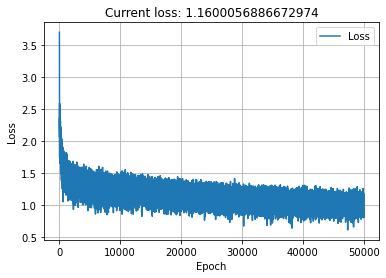

100%|██████████| 50000/50000 [22:33<00:00, 36.95it/s]


In [47]:
train_loss_lst = []
plot_tick = 100

for i in tqdm(range(n_epochs)):
    batch_ix = to_matrix(sample(sequences, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq = rnn_loop(model, batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape(-1, dict_size), actual_next_tokens.reshape(-1))
    
    # train with backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss_lst.append(loss.data.to('cpu').numpy())

    if (i + 1) % plot_tick == 0:
        clear_output(True)
        plt.plot(train_loss_lst, label='Loss')
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f"Current loss: {np.mean(train_loss_lst[:-100])}")
        plt.show()

assert np.mean(train_loss_lst[:10]) > np.mean(train_loss_lst[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [81]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

def generate_text(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = model.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = model(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = model(x_sequence[:, -1], hid_state)
        p_next = nn.functional.softmax(logp_next.detach() / temperature, dim=-1).data.detach().to('cpu').numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(dict_size, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.to('cpu').numpy()[0]])

In [56]:
seed_text = sequences[0].split(' ')[:2]
print('Real text:\n')
print(''.join([sequences[i].strip('|') for i in range(5)]))
seed_text = ' '.join(seed_text)
print(f'text seed: {seed_text}')

Real text:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,

text seed: from fairest


In [82]:
length = 500
temperature = 0.2
generate_text(model, seed_text, length, temperature)

/home/aslan/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


'from fairest the with the with the sure and the love the seeds of the sure the prown the sure my love the so me the with the see the so the worth the sweet i self the see the worth the seem the stare the sing the see thou art thou art the see the see the deart the stall the wair the wert the with the sone and the see the see a see the worth the seep the see the self the so beauty the see the stare the strease the with the self the the with the with the seeds of the seem the sure the sone of the '

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)